# Building an Intelligent Customer Support Agent with LangGraph

## Overview
This tutorial demonstrates how to create an intelligent customer support agent using LangGraph, a powerful tool for building complex language model workflows. The agent is designed to categorize customer queries, analyze sentiment, and provide appropriate responses or escalate issues when necessary.

## Motivation
In today's fast-paced business environment, efficient and accurate customer support is crucial. Automating the initial stages of customer interaction can significantly reduce response times and improve overall customer satisfaction. This project aims to showcase how advanced language models and graph-based workflows can be combined to create a sophisticated support system that can handle a variety of customer inquiries.

## Key Components
1. **State Management**: Using TypedDict to define and manage the state of each customer interaction.
2. **Query Categorization**: Classifying customer queries into Technical, Billing, or General categories.
3. **Sentiment Analysis**: Determining the emotional tone of customer queries.
4. **Response Generation**: Creating appropriate responses based on the query category and sentiment.
5. **Escalation Mechanism**: Automatically escalating queries with negative sentiment to human agents.
6. **Workflow Graph**: Utilizing LangGraph to create a flexible and extensible workflow.

## Method Details
1. **Initialization**: Set up the environment and import necessary libraries.
2. **State Definition**: Create a structure to hold query information, category, sentiment, and response.
3. **Node Functions**: Implement separate functions for categorization, sentiment analysis, and response generation.
4. **Graph Construction**: Use StateGraph to define the workflow, adding nodes and edges to represent the support process.
5. **Conditional Routing**: Implement logic to route queries based on their category and sentiment.
6. **Workflow Compilation**: Compile the graph into an executable application.
7. **Execution**: Process customer queries through the workflow and retrieve results.

## Conclusion
This tutorial demonstrates the power and flexibility of LangGraph in creating complex, AI-driven workflows. By combining natural language processing capabilities with a structured graph-based approach, we've created a customer support agent that can efficiently handle a wide range of queries. This system can be further extended and customized to meet specific business needs, potentially integrating with existing customer support tools and databases for even more sophisticated interactions.

The approach showcased here has broad applications beyond customer support, illustrating how language models can be effectively orchestrated to solve complex, multi-step problems in various domains.

## Import necessary libraries


In [ ]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os

# Load environment variables and set OpenAI API key
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

## Define State Structure

We define a `State` class to hold the query, category, sentiment, and response for each customer interaction.

In [2]:
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

## Define Node Functions

These functions represent the different stages of processing a customer query.

In [3]:
def categorize(state: State) -> State:
    """Categorize the customer query into Technical, Billing, or General."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def analyze_sentiment(state: State) -> State:
    """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    """Provide a technical support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_billing(state: State) -> State:
    """Provide a billing support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_general(state: State) -> State:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def escalate(state: State) -> State:
    """Escalate the query to a human agent due to negative sentiment."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

def route_query(state: State) -> str:
    """Route the query based on its sentiment and category."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"

## Create and Configure the Graph

Here we set up the LangGraph, defining nodes and edges to create our customer support workflow.

In [4]:
# Create the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# Add edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

# Set entry point
workflow.set_entry_point("categorize")

# Compile the graph
app = workflow.compile()

## Visualize the Graph

This cell generates and displays a visual representation of our LangGraph workflow.

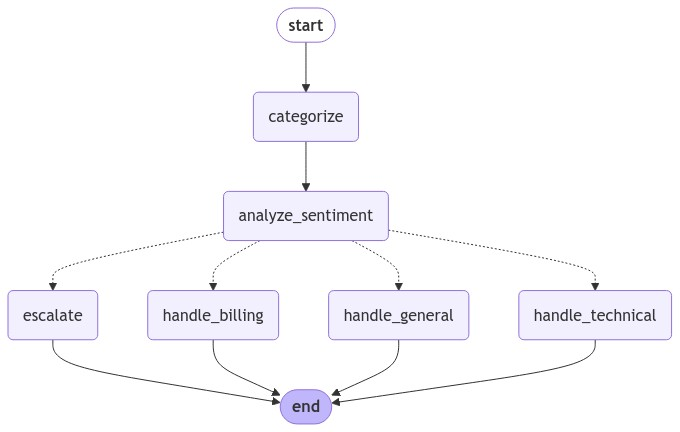

In [5]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run Customer Support Function

This function processes a customer query through our LangGraph workflow.

In [6]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.
    
    Args:
        query (str): The customer's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }


## Test the Customer Support Agent

Let's test our customer support agent with a sample queries for each kind of query type.

In [14]:
# escalate

query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

# handle_technical

query = "I need help talking to chatGPT"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

# handle_billing

query = "where can i find my receipt?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

# handle_general

query = "What are your business hours?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


Query: My internet connection keeps dropping. Can you help?
Category: Technical
Sentiment: Negative
Response: This query has been escalated to a human agent due to its negative sentiment.


Query: I need help talking to chatGPT
Category: Technical
Sentiment: Neutral
Response: Hello,

Thank you for reaching out for technical support. To communicate with ChatGPT, you can simply type your message or question in the chatbox provided on the platform. ChatGPT is designed to respond to text inputs and engage in conversation based on the context provided.

If you are experiencing any difficulties in communicating with ChatGPT, please provide more details about the issue you are facing so that we can assist you further. This may include any error messages, specific questions, or any other relevant information that can help us troubleshoot the problem.

We are here to help and will do our best to assist you in effectively communicating with ChatGPT. Thank you for your patience and cooperation.

